In [1]:
%matplotlib inline
import pandas as pd
import sys
import numpy as np
import datetime
import seaborn as sns


In [2]:
#import ML models

from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier


In [7]:
from IPython.core.display import HTML
css = open('../Data/style-table.css').read() + open('../Data/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [8]:
#imports the raw data in chunks. SQL export could not accomodate one CSV dump

USMTO1 = pd.DataFrame.from_csv('../Data/USMTO1.norm.csv', index_col = False)
USMTO2 = pd.DataFrame.from_csv('../Data/USMTO2.norm.csv', index_col = False)
USMTO3 = pd.DataFrame.from_csv('../Data/USMTO3.norm.csv', index_col = False)
USMTO4 = pd.DataFrame.from_csv('../Data/USMTO4.norm.csv', index_col = False)
USMTO5 = pd.DataFrame.from_csv('../Data/USMTO5.norm.csv', index_col = False)

In [9]:
#imports raw data for S&P 500 values and Industrial Production

SP_500 = pd.DataFrame.from_csv('../Data/SP_500.csv', index_col = False)

In [10]:
#re-combines raw data

USMTO_WHOLE = USMTO1.append(USMTO2).append(USMTO3).append(USMTO4).append(USMTO5)

In [11]:
#merges external data with USMTO data

USMTO_WHOLE = USMTO_WHOLE.merge(SP_500, how='inner', on = ['EntryMonth', 'EntryYear'])

In [12]:
#format order date to datetime to prepare for analysis

USMTO_WHOLE['OrderDateFormatted'] = pd.to_datetime(USMTO_WHOLE.OrderDate)

In [13]:
#format changed date to datetime to prepare for analysis

USMTO_WHOLE['ChangedDateFormatted'] = pd.to_datetime(USMTO_WHOLE.ChangedDate)

In [14]:
#format submit date to datetime to prepare for analysis

USMTO_WHOLE['SubmitDateFormatted'] = pd.to_datetime(USMTO_WHOLE.SubmitDate.fillna(''))

In [15]:
#more formatting to get Order Date at End of Month

USMTO_WHOLE['hyphen'] = "-"

USMTO_WHOLE['OrderDateEOM'] = (USMTO_WHOLE.EntryYear.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.EntryMonth.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.OrderDateFormatted.dt.days_in_month.astype(str))

In [16]:
#format OrderDateEOM to datetime

USMTO_WHOLE['OrderDateEOM'] = pd.to_datetime(USMTO_WHOLE['OrderDateEOM'])


In [17]:
#create column DaysLate which indicates how many days late the order was submitted

USMTO_WHOLE['DaysLate'] = (USMTO_WHOLE['SubmitDateFormatted'] - USMTO_WHOLE['OrderDateEOM']).dt.days - 10

In [18]:
#fill all NaN with "0" -> count=141

USMTO_WHOLE['DaysLate'] = USMTO_WHOLE['DaysLate'].fillna('0')

In [19]:
#cast DaysLate and TotalSale as float64

USMTO_WHOLE['DaysLate'] = pd.to_numeric(USMTO_WHOLE['DaysLate'])
USMTO_WHOLE['TotalSale'] = (USMTO_WHOLE['TotalSale'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

In [20]:
#drop un-needed columns

USMTO_WHOLE = USMTO_WHOLE.drop('SubmitDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('OrderDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('ChangedDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsCancel', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('CancelOrderID', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('hyphen', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsMatch', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsIgnore', axis=1)


In [141]:
#creates columns to indicate supercategory of machine type for each order

USMTO_WHOLE['MetalCutting'] = USMTO_WHOLE['TopCategoryName'] == 'METAL CUTTING EQUIPMENT'
USMTO_WHOLE.MetalCutting = USMTO_WHOLE.MetalCutting.astype('int')  

USMTO_WHOLE['MetalForming'] = USMTO_WHOLE['TopCategoryName'] == 'METAL FORMING & FABRICATING EQUIPMENT'
USMTO_WHOLE.MetalForming = USMTO_WHOLE.MetalForming.astype('int')  

USMTO_WHOLE['OtherMT'] = USMTO_WHOLE['TopCategoryName'] == 'OTHER MFG. TECHNOLOGY'
USMTO_WHOLE.OtherMT = USMTO_WHOLE.OtherMT.astype('int')  

USMTO_WHOLE['DaysLate1'] = USMTO_WHOLE['DaysLate'] <= 0
USMTO_WHOLE.DaysLate1 = USMTO_WHOLE.DaysLate1.astype('int')  

USMTO_WHOLE['DaysLate1'] = USMTO_WHOLE['DaysLate'] <= 0
USMTO_WHOLE.DaysLate1 = USMTO_WHOLE.DaysLate1.astype('int')  

USMTO_WHOLE['DaysLate1'] = USMTO_WHOLE['DaysLate'] <= 0
USMTO_WHOLE.DaysLate1 = USMTO_WHOLE.DaysLate1.astype('int')  

USMTO_WHOLE['DaysLate1'] = USMTO_WHOLE['DaysLate'] <= 0
USMTO_WHOLE.DaysLate1 = USMTO_WHOLE.DaysLate1.astype('int')  


In [3]:
#creates columns IsEmailOne, IsEmailTwo, IsCall indicating when reminders are made for a member to submit

USMTO_WHOLE['IsEmailOne'] = USMTO_WHOLE['DaysLate'] >= 1
USMTO_WHOLE.IsEmailOne = USMTO_WHOLE.IsEmailOne.astype('int')       

USMTO_WHOLE['IsEmailTwo'] = USMTO_WHOLE['DaysLate'] >= 5
USMTO_WHOLE.IsEmailTwo = USMTO_WHOLE.IsEmailTwo.astype('int')    

USMTO_WHOLE['IsCall'] = USMTO_WHOLE['DaysLate'] >= 10
USMTO_WHOLE.IsCall = USMTO_WHOLE.IsCall.astype('int')

USMTO_WHOLE['IsBackfill'] = USMTO_WHOLE['DaysLate'] >= 90
USMTO_WHOLE.IsBackfill = USMTO_WHOLE.IsBackfill.astype('int')

USMTO_WHOLE.to_csv('../Data/Intermediate.csv')

NameError: name 'USMTO_WHOLE' is not defined

In [5]:
%matplotlib inline
import pandas as pd
import sys
import numpy as np
import datetime
import seaborn as sns


In [6]:
#import ML models

from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier


In [7]:
#caching data

USMTO_WHOLE = pd.DataFrame.from_csv('../Data/Intermediate.csv', index_col = False)

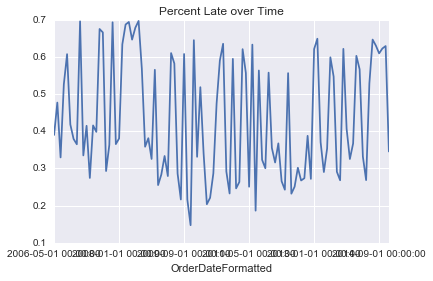

In [8]:
#shows the need to truncate data set

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsEmailOne'].mean().plot(kind = 'line', title = 'Percent Late over Time')

In [9]:
#tosses the former half of data which may not be relevant

USMTO_WHOLE = USMTO_WHOLE[(USMTO_WHOLE.OrderDateFormatted >= '2006-05-01')]

In [10]:
#describes features before tossing some

USMTO_WHOLE.describe()

,Unnamed: 0,Unnamed: 0.1,AAID,NAICSID,Units,TotalSale,IsSubmitted,SubCategory,MachineCode,EntryMonth,...,Close,IP,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,MetalCutting,MetalForming,OtherMT
count,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,3.920680e+05,392068.000000,392068.000000,392068.000000,392068.000000,...,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000
mean,198295.718166,198295.718166,101567.163523,451.643654,0.969559,1.511589e+05,0.999612,26.011322,3568.717931,6.866054,...,1424.766320,100.536678,14.907945,0.440000,0.303307,0.213754,0.031885,0.901091,0.043508,0.055401
std,116256.237362,116256.237362,5267.014327,280.468735,0.234727,2.890960e+05,0.019686,9.751844,384.827128,3.410505,...,282.721568,4.419017,92.569530,0.496388,0.459687,0.409955,0.175694,0.298540,0.203997,0.228762
min,0.000000,0.000000,123.000000,1.000000,-1.000000,-9.861252e+06,0.000000,1.000000,3541.205000,1.000000,...,735.090027,87.412500,-39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,98016.750000,98016.750000,100132.000000,209.000000,1.000000,4.598594e+04,1.000000,23.000000,3541.540000,4.000000,...,1267.380005,97.747400,-4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,196033.500000,196033.500000,100333.000000,248.000000,1.000000,8.190807e+04,1.000000,23.000000,3541.704000,7.000000,...,1397.910034,101.601600,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,298318.250000,298318.250000,100525.000000,749.000000,1.000000,1.650000e+05,1.000000,36.000000,3541.708000,10.000000,...,1549.380005,104.172000,7.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,406559.000000,406559.000000,123556.000000,924.000000,1.000000,4.475133e+07,1.000000,44.000000,9999.999000,12.000000,...,2067.560059,106.686800,3190.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
#create two new tables, one without outliers (outside 2 stdev), and one without backfillers (defined as submitted later than 100 days - per company definition)

USMTO_NO_SUBMIT_OUTLIERS = USMTO_WHOLE[np.abs(USMTO_WHOLE.DaysLate-USMTO_WHOLE.DaysLate.mean())<=(2*USMTO_WHOLE.DaysLate.std())] 
USMTO_NO_SUBMIT_BACKFILL = USMTO_WHOLE[USMTO_WHOLE.DaysLate <= 90]

#source: http://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe


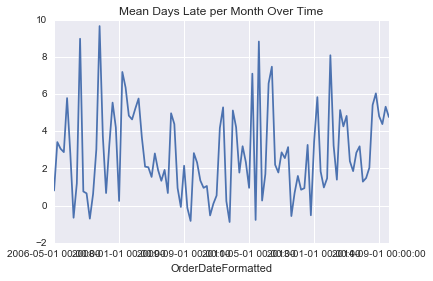

In [12]:
#Plots days late in a time series. Exhibit 1A, to be shared with team.

USMTO_NO_SUBMIT_BACKFILL.groupby(['OrderDateFormatted'])['DaysLate'].mean().plot(kind = 'line', title = 'Mean Days Late per Month Over Time')

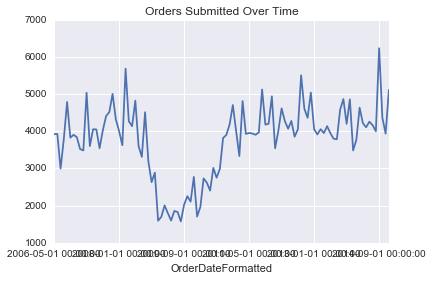

In [13]:
#plot order submission trend. Exhibit 2

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsSubmitted'].sum().plot(kind = 'line', title = 'Orders Submitted Over Time')

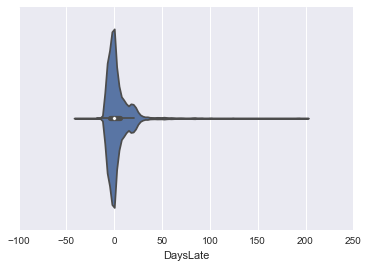

In [14]:
#plots distribution of days late

sns.violinplot(USMTO_NO_SUBMIT_OUTLIERS.DaysLate, title = 'Distribution of Days Late, 1997 to present')


In [15]:
#Creates table by AAID and OrderDateFormatted

AAID_BY_MONTH = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['DaysLate','TotalSale','IsEmailOne', 'IsEmailTwo', 'IsCall', 'IsBackfill','Close','IP'].mean()
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2 = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['Units','TotalSale'].sum()
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH = AAID_BY_MONTH.merge(AAID_BY_MONTH_2, how = 'inner', on = ['AAID','OrderDateFormatted'])
AAID_BY_MONTH['TotalSaleAvg'] = AAID_BY_MONTH['TotalSale_x']
AAID_BY_MONTH['TotalSale'] = AAID_BY_MONTH['TotalSale_y']
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_x', axis = 1)
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_y', axis = 1)
AAID_BY_MONTH.head()

,AAID,OrderDateFormatted,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,Close,IP,Units,TotalSaleAvg,TotalSale
0,123,2007-12-01 00:00:00,522.0,1,1,1,1,1468.359985,105.7256,13,18461.538462,240000.0
1,123,2010-10-01 00:00:00,673.0,1,1,1,1,1183.260010,95.6362,2,100000.000000,200000.0
2,100005,2006-05-01 00:00:00,-5.0,0,0,0,0,1270.089966,102.1531,7,131438.714286,920071.0
3,100005,2006-06-01 00:00:00,1.0,1,0,0,0,1270.199951,102.5220,2,153945.500000,307891.0
4,100005,2006-07-01 00:00:00,-8.0,0,0,0,0,1276.660034,102.5057,11,57971.090909,637682.0


In [16]:
#imports tables to work on, created from CreateAAIDByMonth

#USMTO_WHOLE = pd.DataFrame.from_csv('../Data/USMTO_WHOLE.csv', index_col = False)
AAID_BY_MONTH_NO_BACKFILL = pd.DataFrame.from_csv('../Data/result.csv', index_col = False)
#AAID_BY_MONTH_NO_BACKFILL['DaysLateLastThree'] = pd.to_numeric(AAID_BY_MONTH_NO_BACKFILL['DaysLateLastThree'])
#AAID_BY_MONTH_NO_BACKFILL['TotalSaleLastThree'] = pd.to_numeric(AAID_BY_MONTH_NO_BACKFILL['TotalSaleLastThree'])
AAID_BY_MONTH_NO_BACKFILL = AAID_BY_MONTH_NO_BACKFILL.fillna(value = 0)
#AAID_BY_MONTH = pd.DataFrame.from_csv('../Data/AAID_BY_MONTH.csv', index_col = False)


In [17]:
#look at features

AAID_BY_MONTH_NO_BACKFILL.columns

Index(['Unnamed: 0', 'AAID', 'OrderDateFormatted', 'DaysLate', 'IsEmailOne',
       'IsEmailTwo', 'IsCall', 'IsBackfill', 'Close', 'IP', 'Units',
       'MetalCutting', 'MetalForming', 'OtherMT', 'TotalSaleAvg', 'TotalSale',
       'UnitsLast', 'IsCallLast', 'TotalSaleAvgLast', 'TotalSaleLastThree',
       'DaysLateLastThree', 'DaysLateLast', 'MetalCuttingLast',
       'MetalFormingLast', 'OtherMTLast'],
      dtype='object')

In [18]:
#exports days late by aaid for further analysis

b = AAID_BY_MONTH_NO_BACKFILL.groupby(['AAID'])['DaysLate'].mean()
c = pd.DataFrame(b)
c.to_csv('../Data/DaysLateByAAID',sep = ',')

In [19]:
#scatter matrix identifying key features - target excluded
PAIRPLOT2 = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT2 = PAIRPLOT2.drop('Unnamed: 0',axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('AAID', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('OrderDateFormatted', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailOne', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailTwo', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsBackfill', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSaleAvg', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Units', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSale', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('MetalCutting', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('MetalForming', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('OtherMT', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('MetalCuttingLast', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('MetalFormingLast', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('OtherMTLast', axis = 1)



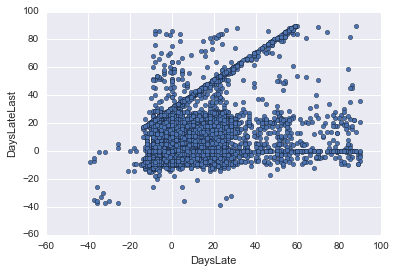

In [20]:
#DaysLate Last vs Days Late (suspicious line - business reason for this, not data error)

AAID_BY_MONTH_NO_BACKFILL.plot.scatter('DaysLate','DaysLateLast')

In [21]:
#prep for correlation matrix - target included. also the dataframe for machine learning algorithms

corr2 = PAIRPLOT2.corr(method = 'pearson')

In [22]:
#Class Distribution

AAID_BY_MONTH_NO_BACKFILL.groupby('IsCall').size()

IsCall
0    12321
1     3719
dtype: int64

In [23]:
#Skew of Attributes

PAIRPLOT2.skew()

DaysLate               2.466051
IsCall                 1.270878
Close                  0.369165
IP                    -0.724223
UnitsLast             11.925780
IsCallLast             1.313808
TotalSaleAvgLast      12.234455
TotalSaleLastThree     5.966600
DaysLateLastThree      1.865813
DaysLateLast           2.516090
dtype: float64

In [24]:
#correlation table

PAIRPLOT2.corr()

,DaysLate,IsCall,Close,IP,UnitsLast,IsCallLast,TotalSaleAvgLast,TotalSaleLastThree,DaysLateLastThree,DaysLateLast
DaysLate,1.000000,0.783191,0.068781,0.108083,-0.017268,0.382425,0.016819,-0.009549,0.446537,0.465693
IsCall,0.783191,1.000000,0.077764,0.122950,-0.028395,0.461439,0.030896,-0.011536,0.451431,0.449449
Close,0.068781,0.077764,1.000000,0.789642,0.036185,0.068478,0.028630,0.067036,0.066066,0.060961
IP,0.108083,0.122950,0.789642,1.000000,0.045953,0.108129,0.030492,0.076427,0.098946,0.095675
UnitsLast,-0.017268,-0.028395,0.036185,0.045953,1.000000,-0.023003,-0.053644,0.779144,-0.010440,-0.012965
IsCallLast,0.382425,0.461439,0.068478,0.108129,-0.023003,1.000000,0.032428,-0.003221,0.648986,0.782168
TotalSaleAvgLast,0.016819,0.030896,0.028630,0.030492,-0.053644,0.032428,1.000000,0.112346,0.032234,0.023663
TotalSaleLastThree,-0.009549,-0.011536,0.067036,0.076427,0.779144,-0.003221,0.112346,1.000000,0.018902,-0.002777
DaysLateLastThree,0.446537,0.451431,0.066066,0.098946,-0.010440,0.648986,0.032234,0.018902,1.000000,0.706479
DaysLateLast,0.465693,0.449449,0.060961,0.095675,-0.012965,0.782168,0.023663,-0.002777,0.706479,1.000000


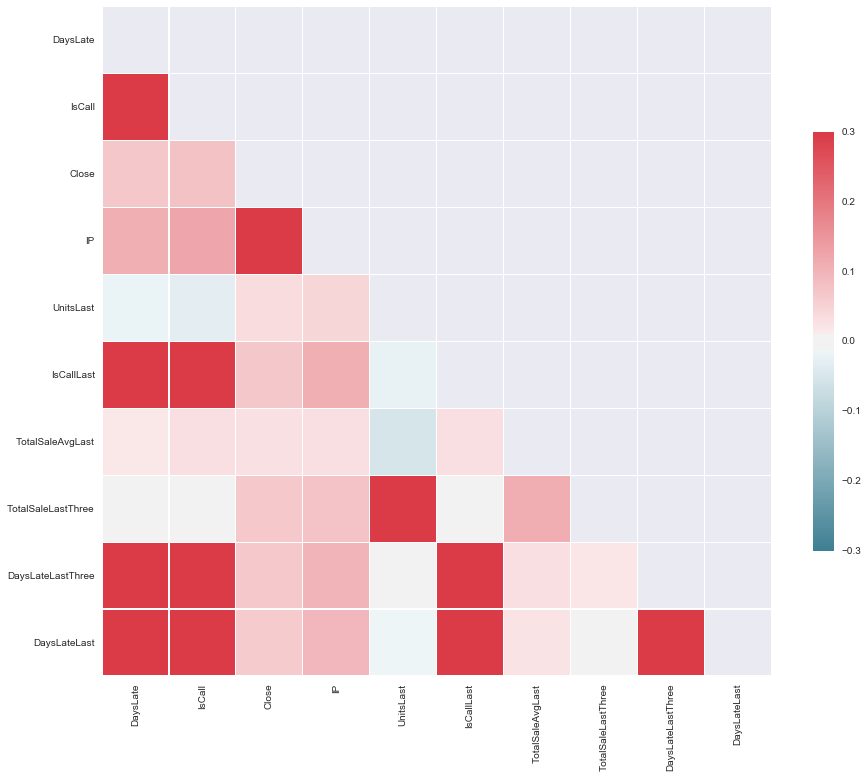

In [25]:
#Correlation Matrix Plot
import matplotlib.pyplot as plt

# Generate a mask for the upper triangle
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


In [26]:
#rescales all data to be between 0 and 1 and readies it for further processing - in progress

import scipy

from sklearn.preprocessing import MinMaxScaler

array = PAIRPLOT2.values
# separate array into input and output components
X = array[:,1:14]
Y = array[:,0]
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X)

#rescaledX3 = rescaledX.reshape((-1,8))

#rescaledX3 = pd.DataFrame({'IsCall':rescaledX[:,0],'Close':rescaledX[:,1],'Three_MMA_Late':rescaledX[:,2],'Three_MMA_SalesTrend':rescaledX[:,3],'DaysLateLastThree':rescaledX[:,4],'TotalSaleLastThree':rescaledX[:,5],'DaysLateLast':rescaledX[:,6],'UnitsLast':rescaledX[:,7],'IsCallLast':rescaledX[:,8]})
#sns.boxplot(data = rescaledX3, orient = 'h', fliersize = '.5')

In [27]:
#describes features

PAIRPLOT2.describe()

,DaysLate,IsCall,Close,IP,UnitsLast,IsCallLast,TotalSaleAvgLast,TotalSaleLastThree,DaysLateLastThree,DaysLateLast
count,16040.000000,16040.000000,16040.000000,16040.000000,16040.000000,16040.000000,1.604000e+04,1.604000e+04,16040.000000,16040.000000
mean,3.852182,0.231858,1388.674964,99.706184,22.592706,0.225499,2.327278e+05,3.403679e+06,3.253616,3.716584
std,14.336176,0.422032,295.474676,4.945777,83.979435,0.417923,4.163287e+05,7.625688e+06,10.696906,14.192845
min,-39.000000,0.000000,735.090027,87.412500,-7.000000,0.000000,-2.639510e+06,-2.828082e+06,-36.333333,-39.000000
25%,-5.000000,0.000000,1186.689941,96.495900,3.000000,0.000000,7.265131e+04,5.162025e+05,-3.666667,-5.000000
50%,0.000000,0.000000,1365.680054,101.038200,8.000000,0.000000,1.377012e+05,1.314886e+06,0.000000,0.000000
75%,8.000000,0.000000,1526.750000,103.526300,19.000000,0.000000,2.596626e+05,3.110017e+06,7.333333,8.000000
max,90.000000,1.000000,2067.560059,106.686800,1867.000000,1.000000,1.700000e+07,9.903093e+07,77.666667,90.000000


In [28]:
#columns which correspond to feature selection output

PAIRPLOT2.columns

Index(['DaysLate', 'IsCall', 'Close', 'IP', 'UnitsLast', 'IsCallLast',
       'TotalSaleAvgLast', 'TotalSaleLastThree', 'DaysLateLastThree',
       'DaysLateLast'],
      dtype='object')

In [29]:
# Feature Importance with Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]

# feature extraction
model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)

[ 0.01795462  0.10681669  0.10758725  0.15414163  0.00375328  0.16703723
  0.16048114  0.16162033  0.12060783]


In [30]:
# Feature Extraction with RFE 

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# load data

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 4)
fit = rfe.fit(X, Y)
print("Num Features: " , fit.n_features_)
print("Selected Features: " , fit.support_)
print("Feature Ranking: " , fit.ranking_)

Num Features:  4
Selected Features:  [ True False False  True  True False False  True False]
Feature Ranking:  [1 4 2 1 1 5 6 1 3]


In [31]:
#we end up using all features

In [32]:
#test different types of models

array = PAIRPLOT2.values
X = array[:,1:14].astype(float)
Y = array[:,0]
validation_size = 0.33
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y,
test_size=validation_size, random_state=seed)
num_folds = 5
num_instances = len(X_train)
seed = 7
scoring = 'accuracy'
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC())) - causes code to hang
results = []
names = []
for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = (name, cv_results.mean(),cv_results.std())
    print(msg)


('LR', 0.072864566537167108, 0.0024797523139381871)


C:\Users\lzhang\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\lzhang\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\lzhang\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\lzhang\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\lzhang\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


('LDA', 0.10292176999577954, 0.0046327332745729139)
('KNN', 0.054346359042063905, 0.0039045834604323855)
('CART', 0.095662969255575867, 0.0032285749426909749)
('NB', 0.046808704968238343, 0.0044160146096923238)


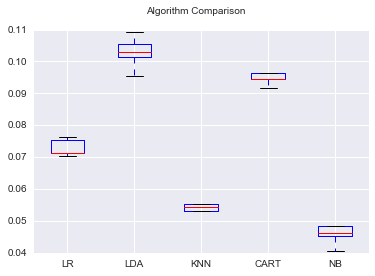

In [33]:
#distribution of models, accuracy and std dev

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [34]:
a = pd.DataFrame({'a':X[:,0],'b':X[:,1],'c':X[:,2],'d':X[:,3],'e':X[:,4],'f':X[:,5],'g':X[:,6]}).head()

print (a.columns)
print (PAIRPLOT2.columns)

Index(['a', 'b', 'c', 'd', 'e', 'f', 'g'], dtype='object')
Index(['DaysLate', 'IsCall', 'Close', 'IP', 'UnitsLast', 'IsCallLast',
       'TotalSaleAvgLast', 'TotalSaleLastThree', 'DaysLateLastThree',
       'DaysLateLast'],
      dtype='object')


In [35]:
>>> from sklearn import tree
>>>
>>> clf = tree.DecisionTreeClassifier()
>>> clf = clf.fit(X_train, Y_train)
>>> tree.export_graphviz(clf,
...     out_file='usmto3.dot',feature_names = a.columns)   

IndexError: index 7 is out of bounds for axis 0 with size 7

In [ ]:
>>> from sklearn.externals.six import StringIO
>>> with open("usmto3.dot", 'w') as f:
...     f = tree.export_graphviz(clf, out_file=f)

>>> import os
>>> os.unlink('usmto3.dot')

In [ ]:
#classification report with best model (Decision Trees)

from sklearn.metrics import classification_report

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

In [ ]:
# Cross Validation Classification LogLoss (smaller logloss better with 0 as perfect logloss)


from sklearn import cross_validation
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = LinearDiscriminantAnalysis()
scoring = 'log_loss'
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring = scoring)
print("Logloss: ", results.mean(), "      Std Dev: ", results.std())

In [ ]:
# Cross Validation Classification with Area Under the Curve (Between 0.5 and 1 indicates good model)


from sklearn import cross_validation
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = LinearDiscriminantAnalysis()
scoring = 'roc_auc'
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring = scoring)
print("AUC: ", results.mean(), "      Std Dev: ", results.std())


In [ ]:
#average sales over time

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).sum()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='TotalSale')

In [ ]:
#plot of orders submitted over time

USMTO_WHOLE.groupby(['OrderDateFormatted'])['TotalSale'].sum().plot(kind = 'line', title = 'Sum of Order Dollars')

In [ ]:
#percentage of company by month who needed to be called

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsCall')

In [ ]:
#percentage of company by month who needed to have first email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailOne')

In [ ]:
#percentage of company by month who needed to have second email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailTwo')

In [ ]:
#percentage of company by month who backfilled

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsBackfill')

In [ ]:
********BREAK**********

In [ ]:
USMTO_WHOLE['MachineCategory'] == 1 if USMTO_WHOLE.TopCategoryName == 'METAL CUTTING EQUIPMENT' else USMTO_WHOLE['MachineCategory'] == 2

In [ ]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


In [ ]:

# Import some data to play with
array = PAIRPLOT2.values
X = array[:,1:14]
y = array[:,0]

# Binarize the output
y = label_binarize(y, classes=[0, 1])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)


In [ ]:

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#APPENDIX AS FOLLOWS: (works in progress)

In [ ]:
#cols to create:

#3 MMA company sales
#3 MMA lateness
# s&p 500 
machine tool mix
#prior month late days
# scatter matrix



In [ ]:
#attempts to map which AAIDs submitted over what dates

AAIDs = pd.DataFrame.from_csv('AAIDs.csv', index_col = False)

In [ ]:
AAIDs = AAIDs.fillna('')

In [ ]:
AAIDs

In [ ]:
#plots distribution who received a first email, over all time

USMTO_WHOLE.groupby('OrderDateFormatted')['IsEmailOne'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsEmailTwo'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsCall'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsBackfill'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE